In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import os
from pathlib import Path
os.environ["OMP_NUM_THREADS"] = "4"

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

### csv compiling function

In [3]:
import os
import pandas as pd
from pathlib import Path

def compile_prediction_data(datasets=None, models=None, max_days=None, pred_lengths=None, base_dir=None):
    """
    Compiles prediction data from specified models, max_days, and prediction lengths into a single DataFrame.
    Uses the current working directory by default.
    
    Parameters:
    -----------
    datasets : list, optional
        List of datasets to include ('coop', 'tafeng'). If None, includes all datasets
    models : list, optional
        List of models to include. If None, includes all models
    max_days : list, optional
        List of max_days values to include. If None, includes all max_days
    pred_lengths : list, optional
        List of prediction lengths to include. If None, includes all pred_lengths
    base_dir : str, optional
        Base directory containing the 'forgotten' folder. If None, uses current working directory
    
    Returns:
    --------
    pd.DataFrame
        Combined DataFrame containing all specified prediction data
    """
    # Use current working directory if base_dir is not specified
    base_path = Path(base_dir if base_dir is not None else os.getcwd()) / 'forgotten'
    
    # Default values if None
    all_datasets = ['coop', 'tafeng']
    all_models = ['top', 'markov', 'ibp', 'nmf', 'fpmc', 'clf', 'hrm', 'tbp', 'xmt', 'tars_xmt_final_sum']
    all_max_days = [0, 1, 2]
    
    # Use provided values or defaults
    datasets = datasets if datasets is not None else all_datasets
    models = models if models is not None else all_models
    max_days = max_days if max_days is not None else all_max_days
    
    # Initialize empty list to store DataFrames
    dfs = []
    
    # Iterate through the directory structure
    for dataset in datasets:
        dataset_path = base_path / dataset
        
        if not dataset_path.exists():
            print(f"Warning: Dataset path {dataset_path} does not exist")
            continue
            
        for model in models:
            model_path = dataset_path / model
            
            if not model_path.exists():
                print(f"Warning: Model path {model_path} does not exist")
                continue
                
            # Look through all split directories (split_10 to split_90)
            split_dirs = [d for d in model_path.glob('split_*')]
            
            for split_dir in split_dirs:
                for max_day in max_days:
                    max_day_path = split_dir / str(max_day)
                    
                    if not max_day_path.exists():
                        continue
                    
                    # Find all prediction files for specified prediction lengths
                    for file in max_day_path.glob('pred_forgot_*.csv'):
                        # Extract pred_length from filename
                        filename = file.name
                        file_pred_length = int(filename.split('_')[-1].replace('.csv', ''))
                        
                        # Skip if pred_lengths is specified and this file's pred_length isn't in it
                        if pred_lengths is not None and file_pred_length not in pred_lengths:
                            continue
                            
                        try:
                            # Read and append the CSV file as is
                            df = pd.read_csv(file)
                            dfs.append(df)
                        except Exception as e:
                            print(f"Error reading file {file}: {str(e)}")
    
    if not dfs:
        print("No matching files found")
        return pd.DataFrame()
    
    # Combine all DataFrames
    final_df = pd.concat(dfs, ignore_index=True)
    return final_df

### plot function

In [4]:
def plot_metrics_by_split(df, metric, color='#ADD8E6', figsize_width=20, figsize_height=5,
                         k_font_size=10, score_font_size=10, split_font_size=10,
                         title_font_size=12, suptitle_font_size=14, save_path=None, dpi=900):
    """
    Creates a row of boxplots showing the distribution of a specified metric across different split types,
    with separate plots for each prediction length. Y-axis label only appears on the leftmost plot.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the prediction results
    metric : str
        Name of the metric column to plot (e.g., 'f1_score', 'precision', 'recall')
    color : str, optional
        Color of the boxplots (default: '#ADD8E6' - light blue)
    figsize_width : int, optional
        Width of the entire figure (default: 20)
    figsize_height : int, optional
        Height of each subplot (default: 5)
    k_font_size : int, optional
        Font size for k values in subplot titles (default: 10)
    score_font_size : int, optional
        Font size for score values (y-axis) (default: 10)
    split_font_size : int, optional
        Font size for split type values (x-axis) (default: 10)
    title_font_size : int, optional
        Font size for axis titles (default: 12)
    suptitle_font_size : int, optional
        Font size for figure suptitle (default: 14)
    save_path : str, optional
        If provided, path where the figure will be saved as PNG (default: None)
    dpi : int, optional
        DPI (dots per inch) for saved figure (default: 900)
    
    Returns:
    --------
    matplotlib.figure.Figure
        The generated figure containing all subplots
    """
    # Get unique prediction lengths
    pred_lengths = sorted(df['pred_length'].unique())
    n_plots = len(pred_lengths)
    
    # Extract split numbers from split_mode column using raw string
    df['split_number'] = df['split_mode'].astype(str).str.extract(r'(\d+)').astype(int)
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, n_plots, figsize=(figsize_width, figsize_height))
    
    # Handle case where there's only one pred_length
    if n_plots == 1:
        axes = [axes]
    
    # Create a boxplot for each prediction length
    for i, (ax, pred_len) in enumerate(zip(axes, pred_lengths)):
        # Filter data for current prediction length
        pred_len_data = df[df['pred_length'] == pred_len]
        
        # Create boxplot with specified color
        sns.boxplot(data=pred_len_data, x='split_number', y=metric, ax=ax, color=color)
        
        # Customize plot
        ax.set_title(f'k = {pred_len}', fontsize=k_font_size)
        ax.set_xlabel('Split Type', fontsize=title_font_size)
        
        # Only set y-axis label for the leftmost plot
        if i == 0:
            ax.set_ylabel(metric.replace('_', ' ').title(), fontsize=title_font_size)
        else:
            ax.set_ylabel('')  # Remove y-axis label for other plots
        
        # Set x-axis ticks
        ax.set_xticks(range(len(pred_len_data['split_number'].unique())))
        ax.set_xticklabels(sorted(pred_len_data['split_number'].unique()), fontsize=split_font_size)
        
        # Set y-axis tick font size
        ax.tick_params(axis='y', labelsize=score_font_size)
        
        # Add grid for better readability
        ax.grid(True, alpha=0.3)
    
    # Add suptitle with italicized k
    plt.suptitle('Impact of $\it{k}$ on F1 Score and Recall', fontsize=suptitle_font_size)
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    # Adjust the layout to make room for suptitle
    plt.subplots_adjust(top=0.85)
    
    # Save the figure if save_path is provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight')
    
    return fig

<>:83: SyntaxWarning: invalid escape sequence '\i'
<>:83: SyntaxWarning: invalid escape sequence '\i'
C:\Users\javie\AppData\Local\Temp\ipykernel_13220\423235329.py:83: SyntaxWarning: invalid escape sequence '\i'
  plt.suptitle('Impact of $\it{k}$ on F1 Score and Recall', fontsize=suptitle_font_size)


### Coop xmt

In [5]:
df = compile_prediction_data(
    datasets=['coop'],
    models=['xmt'],
    max_days=[2],
    pred_lengths=[5, 10, 15, 20]
)

In [6]:
df.head()

,dataset_name,category_mode,split_mode,model_name,training_time,customer_id,pred_time,next_basket_number,pred_length,curr_basket_id,curr_basket,fut_basket_id,fut_basket,pred_basket,precision,recall,f1_score,f05_score,f2_score,hit_score
0,coop,category,30,xmt,0:00:04.745715,67656,0:00:00.000456,1,5,2010_06_17_25,"ice_cream,frozen_fish,water,wine,detergenti_superfici,milk,prod_sanitari_paramed,modellini_e_giochi_bambino,fresh_pasta,trattamento_cosmetico_uomo",2010_06_19_25,"avvolgenti_cucina,prod_lavastoviglie,frozen_fish,water,hazelnut_fruit,beers,drinks,stoviglie_plastica,apple,bread,piante_da_interno,prod_sport_mare_donna,fresh_aromas","salumi,chicken,fat_food,avvolgenti_cucina,fresh_cheese",0.2,0.076923,0.111111,0.181818,0.052632,1.0
1,coop,category,30,xmt,0:00:04.745715,67658,0:00:00.000365,1,5,2009_12_07_70,"red_meat,prod_detergenza_tessuti,canned_tomatoes,biscuited_slices,bread,turkey,vegetables,salad,frozen_meat",2009_12_09_70,"bovine,salumi,water,red_meat,canned_vegetables,citrus,milk,bread,rabbit,turkey,olive_oil,pig,frozen_vegetables","bovine,salumi,water,milk,fresh_cheese",0.8,0.307692,0.444444,0.727273,0.210526,1.0
2,coop,category,30,xmt,0:00:04.745715,67659,0:00:00.000411,1,5,2010_03_25_70,"pears,bovine,salumi,chocolate,chicken,canned_tomatoes,citrus,banana,milk,strawberry_and_berry,saponi_e_spugne,sheep,potatoes,prod_pulizia_pavimento,pannolini_igiene_infanzia,salad,carta_usa_e_getta",2010_03_27_70,"kiwi,red_meat,jam_and_marmelade,stoviglie_plastica,citrus,milk,alcoholic_drinks,bread,apple,vegetables","onions_and_garlic,detergenti_superfici,apple,bread,vegetables",0.6,0.300000,0.400000,0.600000,0.200000,1.0
3,coop,category,30,xmt,0:00:04.745715,67661,0:00:00.000301,1,5,2008_01_02_25,"bovine,fat_food,lampade,fresh_cheese,food_animals,water,completamento_igiene_persona,milk,biscuited_slices,chicken,citrus,bread,vegetables,dessert,fresh_pasta,prod_detergenza_tessuti,carta_usa_e_getta,carta_igienica,tomatoes,olive_oil,eggs,cura_tessuti",2008_01_02_70,"bovine,christmas_food,water,chocolate,pastry,drinks,stoviglie_plastica,citrus,tovaglie_tovaglioli,bread,apple,vegetables,cura_tessuti,frozen_vegetables,candies","grana_cheese,banana,snacks,dried_fruit,canned_fish",0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,coop,category,30,xmt,0:00:04.745715,67662,0:00:00.000423,1,5,2015_02_19_25,"intimo_giorno_uomo,food_animals,prodotti_capelli,water,fat_food,intimo_notte_uomo,pile,pantaloni_uomo,pantofole_uomo,calzature_ivernali_estive_donna,candies",2015_02_20_25,"fat_food,detergenti_superfici,fresh_cheese,flour,milk,pasta,calzature_ivernali_estive_donna,abbigliamento_sportivo,prod_lavastoviglie,canned_vegetables,drinks,seed_oil,canned_tomatoes,bread,accessori_abbigliamento_donna,snacks,canned_fish,calzetteria_donna,grana_cheese,banana","flavoring,bovine,chicken,apple,fresh_cheese",0.2,0.050000,0.080000,0.150000,0.035294,1.0


In [7]:
sorted_df = df.sort_values(by=df.columns[:3].tolist()).reset_index(drop=True)
sorted_df.head()

,dataset_name,category_mode,split_mode,model_name,training_time,customer_id,pred_time,next_basket_number,pred_length,curr_basket_id,curr_basket,fut_basket_id,fut_basket,pred_basket,precision,recall,f1_score,f05_score,f2_score,hit_score
0,coop,category,10,xmt,0:00:02.201776,67656,0:00:00.000370,1,10,2008_05_27_25,"ice_cream,prod_cura_corpo_viso,water,red_meat,cereals_brekfast,prod_igiene_orale,chicken,drinks,calzetteria_bambini,stoviglie_plastica,piante_da_interno,fresh_cheese,candies",2008_05_29_25,"flavoring,salumi,water,beers,grana_cheese,seed_oil,canned_tomatoes,stoviglie_plastica,detergenti_superfici,wine,generic_food,seasoned_cheese,contenitori_immagini","salumi,grana_cheese,fat_food,wine,detergenti_superfici,breakfast_food,milk,prod_pulizia_pavimento,avvolgenti_cucina,honey",0.4,0.307692,0.347826,0.452830,0.193548,1.0
1,coop,category,10,xmt,0:00:02.201776,67658,0:00:00.000313,1,10,2007_12_22_70,"food_animals,bovine,salumi,water,red_meat,canned_vegetables,fat_food,canned_tomatoes,milk,bread,pasta,pig,carta_per_ricorrenze",2007_12_24_25,"food_animals,bovine,flavoring,christmas_food,chocolate,eggs,coffee,prod_igiene_orale,flour,carta_igienica,tovaglie_tovaglioli,bread,sheep,potatoes,rabbit,vegetables,salad,dried_fruit","grana_cheese,chicken,seed_oil,carta_igienica,turkey,rabbit,vegetables,salad,fresh_cheese,canned_fish",0.4,0.222222,0.285714,0.413793,0.146341,1.0
2,coop,category,10,xmt,0:00:02.201776,67659,0:00:00.000452,1,10,2010_03_25_70,"pears,bovine,salumi,chocolate,chicken,canned_tomatoes,citrus,banana,milk,strawberry_and_berry,saponi_e_spugne,sheep,potatoes,prod_pulizia_pavimento,pannolini_igiene_infanzia,salad,carta_usa_e_getta",2010_03_27_70,"kiwi,red_meat,jam_and_marmelade,stoviglie_plastica,citrus,milk,alcoholic_drinks,bread,apple,vegetables","water,eggs,onions_and_garlic,detergenti_superfici,apple,bread,pasta,cookies,vegetables,cura_tessuti",0.3,0.300000,0.300000,0.360000,0.180000,1.0
3,coop,category,10,xmt,0:00:02.201776,67661,0:00:00.000293,1,10,2007_10_31_70,"ice_cream,red_meat,dessert,jam_and_marmelade,carta_igienica,frozen_vegetables,melted_cheese,bread,vegetables,sugar,intimi_assorbenti,prod_detergenza_tessuti,dried_fruit,yogurt",2007_11_02_25,"prodotti_capelli,chocolate,canned_vegetables,grana_cheese,coffee,onions_and_garlic,wine,cookies,vegetables,olive_oil,intimi_assorbenti,dried_fruit,fresh_aromas,carta_usa_e_getta","food_animals,water,chicken,tomatoes,milk,olive_oil,eggs,snacks,fresh_cheese,canned_fish",0.1,0.071429,0.083333,0.111111,0.045455,1.0
4,coop,category,10,xmt,0:00:02.201776,67662,0:00:00.000446,1,10,2015_02_19_25,"intimo_giorno_uomo,food_animals,prodotti_capelli,water,fat_food,intimo_notte_uomo,pile,pantaloni_uomo,pantofole_uomo,calzature_ivernali_estive_donna,candies",2015_02_20_25,"fat_food,detergenti_superfici,fresh_cheese,flour,milk,pasta,calzature_ivernali_estive_donna,abbigliamento_sportivo,prod_lavastoviglie,canned_vegetables,drinks,seed_oil,canned_tomatoes,bread,accessori_abbigliamento_donna,snacks,canned_fish,calzetteria_donna,grana_cheese,banana","flavoring,bovine,prod_lavastoviglie,chicken,grana_cheese,drinks,apple,prepared_food,fresh_pasta,fresh_cheese",0.4,0.200000,0.266667,0.400000,0.133333,1.0


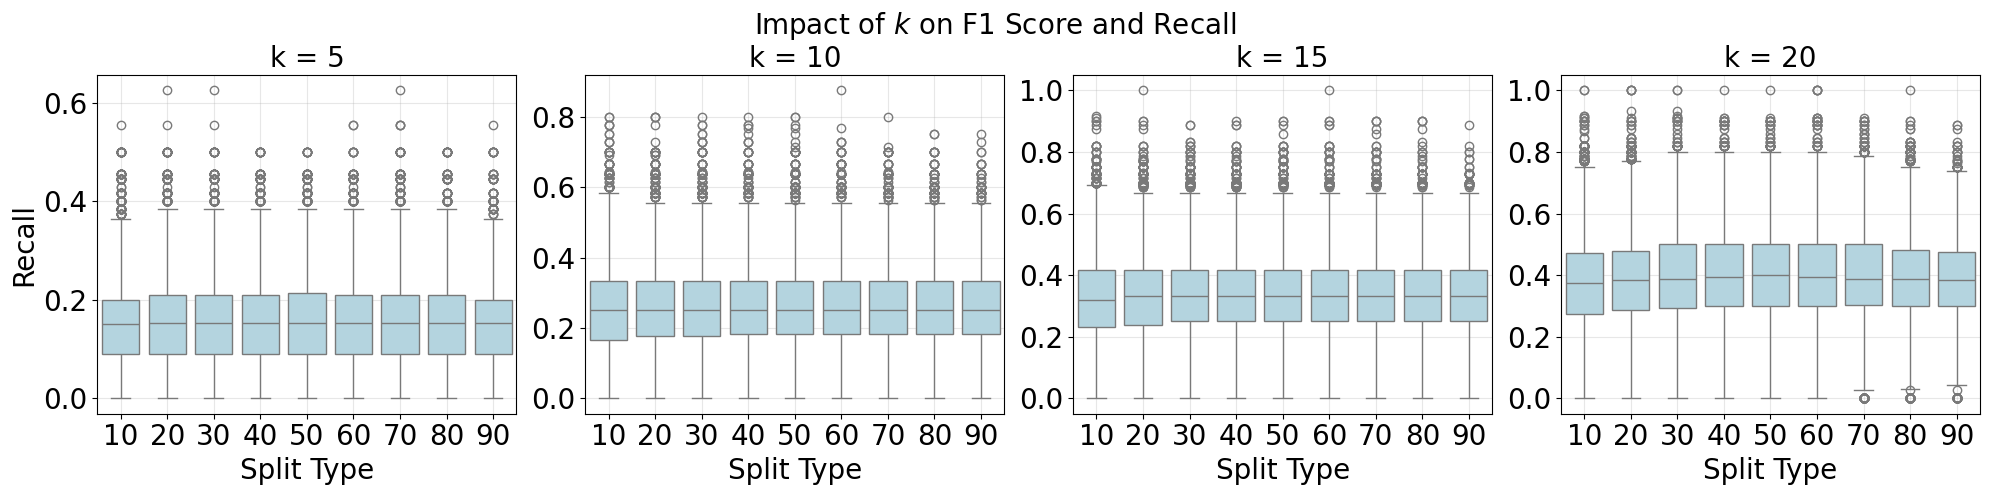

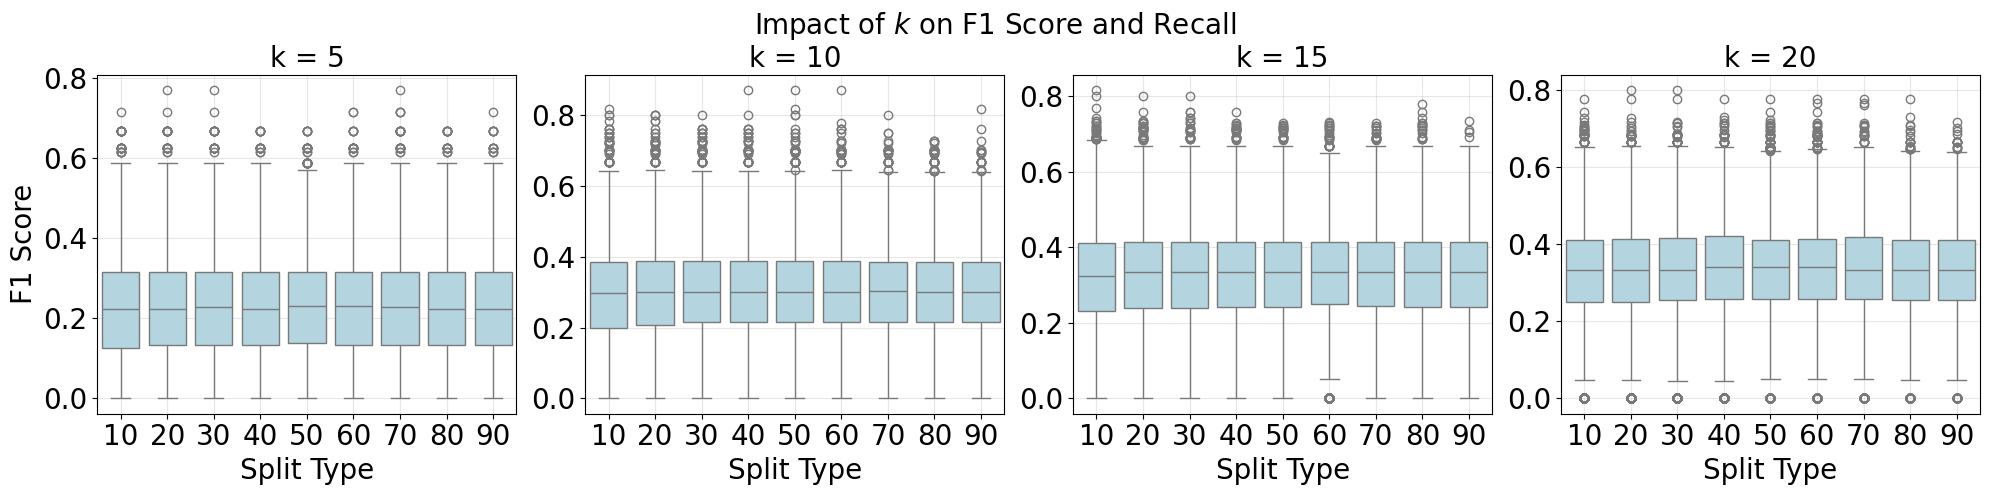

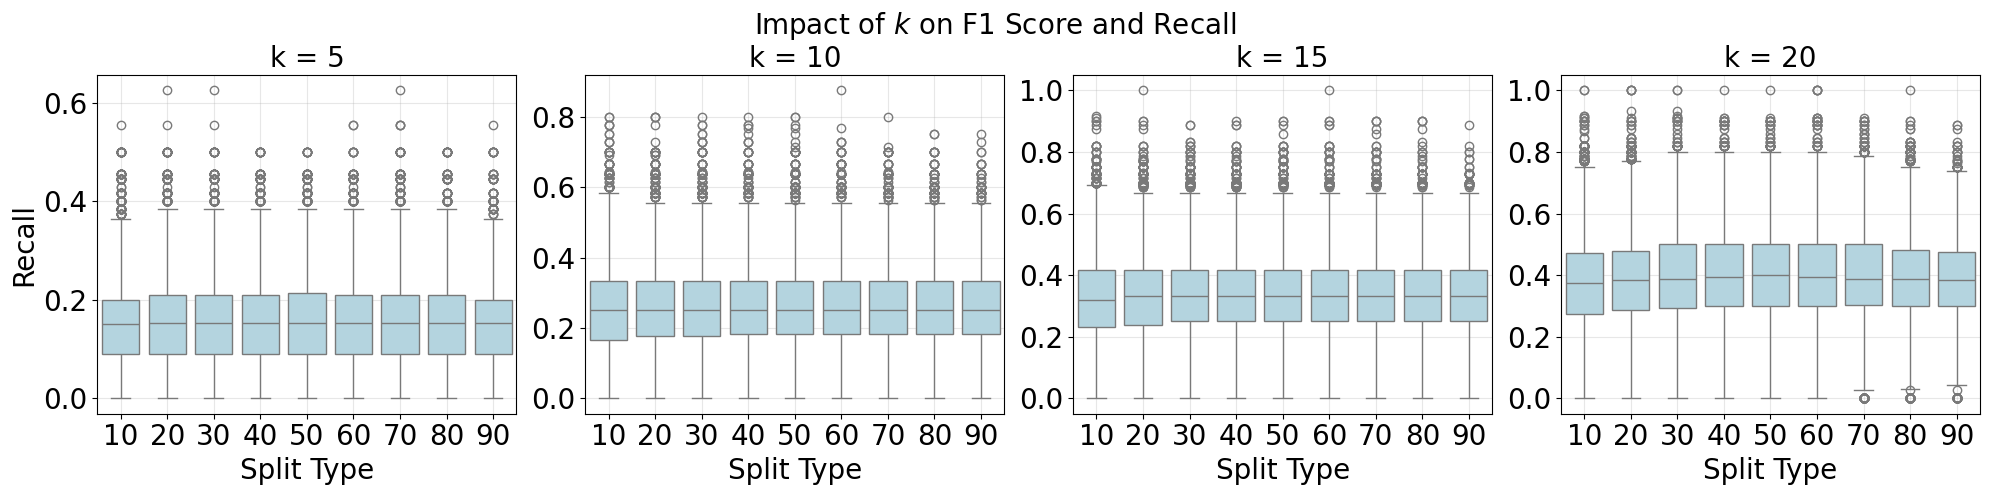

In [15]:
# plot_metrics_by_split(df, metric, figsize_width=20, figsize_height=5)

# plot_metrics_by_split(df, 'f1_score')
# plt.show()

# # You can also create plots for other metrics
# plot_metrics_by_split(df, 'precision')
# plt.show()

# plot_metrics_by_split(df, 'recall')
# plt.show()

plot_metrics_by_split(df, 'f1_score', 
                     k_font_size=20,
                     score_font_size=20,
                     split_font_size=20,
                     title_font_size=20,
                     suptitle_font_size=20,
                     save_path='boxplots_xmt_f1.png')  # Will save with default 900 DPI

plot_metrics_by_split(df, 'recall', 
                     k_font_size=20,
                     score_font_size=20,
                     split_font_size=20,
                     title_font_size=20,
                     suptitle_font_size=20,
                     save_path='boxplots_xmt_recall.png')  # Will save with default 900 DPI

### txmt

In [9]:
df = compile_prediction_data(
    datasets=['coop'],
    models=['tars_xmt_final_sum'],
    max_days=[2],
    pred_lengths=[5, 10, 15, 20]
)

In [10]:
df.head()

,dataset_name,category_mode,split_mode,model_name,training_time,customer_id,pred_time,next_basket_number,pred_length,curr_basket_id,curr_basket,fut_basket_id,fut_basket,pred_basket,precision,recall,f1_score,f05_score,f2_score,hit_score
0,coop,category,90,tars_xmt_final_sum,0:00:09.594615,67656,0:00:00.000030,1,5,2015_11_21_25,"candies,water,addobbo_natalizio,tea,prod_lavastoviglie,accessori_tessile_casa,cereals_brekfast,chocolate,christmas_food,canned_tomatoes,stoviglie_plastica,bread",2015_11_23_25,"bovine,frozen_prepared_food,prod_cura_corpo_viso,eggs,ice_cream,rabbit,ricariche_e_attivazioni_telefoniche,frozen_fish,frozen_vegetables,fat_food,yogurt,vegetables,salumi","bovine,chicken,ice_cream,frozen_vegetables,salumi",0.8,0.307692,0.444444,0.727273,0.210526,1.0
1,coop,category,90,tars_xmt_final_sum,0:00:13.355950,72220,0:00:00.000019,1,5,2015_10_22_68,"canned_tomatoes,citrus,prod_per_riporre,accessori_calzature,dried_fruit,vegetables,onions_and_garlic,bovine,yogurt,fish",2015_10_24_68,"water,intimi_assorbenti,cura_tessuti,citrus,dried_fruit,deodoranti_ambienti,kiwi,grapes,cereals_brekfast,prod_igiene_orale,banana","fresh_cheese,salumi,pasta,seafood,milk",0.0,0.000000,0.000000,0.000000,0.000000,0.0
2,coop,category,90,tars_xmt_final_sum,0:00:08.937862,69175,0:00:00.000023,1,5,2016_03_08_25,"pastry,fish,frozen_fish,salumi,rabbit,seed_oil,easter_food,frozen_vegetables,calzetteria_donna,oggettistica,bread,chicken",2016_03_10_25,"frozen_prepared_food,citrus,cookies,apple,frozen_flour,bovine,fresh_pasta,seasoned_cheese,wine,food_animals,red_meat,carta_usa_e_getta,fat_food","water,frozen_flour,cookies,vegetables,flavoring",0.4,0.153846,0.222222,0.363636,0.105263,1.0
3,coop,category,90,tars_xmt_final_sum,0:00:16.308040,80443,0:00:00.000016,1,5,2015_12_13_97,"fruit_juices,bovine,prod_lavastoviglie,canned_tomatoes,salumi,onions_and_garlic,bread,fresh_pasta,seasoned_cheese,milk",2015_12_14_59,"candies,christmas_food,red_meat,frozen_fish,wine,prepared_food,citrus,spirits,pasta,frozen_vegetables,fresh_pasta,intimi_assorbenti,water","turkey,prepared_food,citrus,pastry,frozen_vegetables",0.6,0.230769,0.333333,0.545455,0.157895,1.0
4,coop,category,90,tars_xmt_final_sum,0:00:02.832188,81745,0:00:00.000027,1,5,2016_08_02_69,"fat_food,dried_fruit,apple,chocolate,cura_tessuti,salumi,grana_cheese,ice_cream,eggs,dessert,jam_and_marmelade,watermelon,canned_vegetables,hazelnut_fruit,fresh_cheese,pears,yogurt,milk,cookies,tomatoes",2016_08_03_69,"vinegar,piante_da_interno,dessert,bread,pastry,sugar,water,vegetables,citrus,lettura_promozionale,yogurt,banana,drinks,beers","bread,water,vegetables,quotidiani_e_riviste,banana",0.8,0.285714,0.421053,0.705882,0.196721,1.0


In [11]:
df['model_name'] = df['model_name'].replace('tars_xmt_final_sum', 'txmt')


In [12]:
sorted_df = df.sort_values(by=df.columns[:3].tolist()).reset_index(drop=True)
sorted_df.head()

,dataset_name,category_mode,split_mode,model_name,training_time,customer_id,pred_time,next_basket_number,pred_length,curr_basket_id,curr_basket,fut_basket_id,fut_basket,pred_basket,precision,recall,f1_score,f05_score,f2_score,hit_score
0,coop,category,10,txmt,0:00:03.402731,67656,0:00:00.000014,1,5,2008_05_27_25,"candies,drinks,water,piante_da_interno,prod_cura_corpo_viso,chicken,ice_cream,prod_igiene_orale,cereals_brekfast,fresh_cheese,stoviglie_plastica,red_meat,calzetteria_bambini",2008_05_29_25,"beers,seed_oil,water,seasoned_cheese,grana_cheese,flavoring,contenitori_immagini,generic_food,detergenti_superfici,canned_tomatoes,wine,stoviglie_plastica,salumi","grana_cheese,breakfast_food,detergenti_superfici,wine,salumi",0.8,0.307692,0.444444,0.727273,0.210526,1.0
1,coop,category,10,txmt,0:00:02.500859,69175,0:00:00.000014,1,5,2008_08_28_25,"milk,fish,cura_tessuti,fresh_cheese,watermelon,hazelnut_fruit,salumi,frozen_flour,olive_oil,carta_igienica,water,pasta,tomatoes,prod_lavastoviglie,bread,snacks",2008_08_30_70,"pastry,frozen_prepared_food,maglieria_esterno_uomo,canned_tomatoes,watermelon,banana,flavoring,frozen_fish,frozen_flour,vegetables,sauce,tomatoes,ice_cream,bread,canned_fish","frozen_prepared_food,yogurt,frozen_vegetables,dessert,ice_cream",0.4,0.133333,0.200000,0.342857,0.092308,1.0
2,coop,category,10,txmt,0:00:05.143325,67658,0:00:00.000011,1,5,2007_12_22_70,"bovine,water,canned_vegetables,pig,canned_tomatoes,food_animals,milk,fat_food,bread,red_meat,pasta,carta_per_ricorrenze,salumi",2007_12_24_25,"bovine,coffee,dried_fruit,carta_igienica,eggs,sheep,salad,rabbit,flavoring,flour,christmas_food,chocolate,food_animals,tovaglie_tovaglioli,bread,potatoes,vegetables,prod_igiene_orale","canned_fish,carta_igienica,salad,rabbit,fresh_cheese",0.6,0.166667,0.260870,0.473684,0.116883,1.0
3,coop,category,10,txmt,0:00:04.329988,69177,0:00:00.000013,1,5,2008_03_05_68,"milk,cookies,prepared_food,prodotti_chimici_nutrimento,vegetables,olives,eggs,mushrooms,bread,chicken",2008_03_07_68,"fresh_cheese,apple,pasta,bread,fat_food,fresh_aromas,salumi,bovine,vegetables,alberi_e_arbusti_esterni,flavoring,fresh_pasta,drinks,milk,citrus,pig,frozen_vegetables,tomatoes,chicken","pig,salumi,bovine,biscuited_slices,fresh_pasta",0.8,0.210526,0.333333,0.615385,0.148148,1.0
4,coop,category,10,txmt,0:00:00.563564,70649,0:00:00.000010,1,5,2015_05_26_83,"water,candies,tovaglie_tovaglioli,beers,fresh_cheese,tomatoes,vegetables,bread,yogurt,canned_tomatoes",2015_05_28_83,"fish,wine,ice_cream,tovaglie_tovaglioli,tomatoes,alcoholic_drinks,olive_oil,seafood,vegetables,pasta,bread,esotic_fruit,fresh_aromas,strawberry_and_berry,canned_tomatoes",wine,1.0,0.066667,0.125000,0.315789,0.049180,1.0


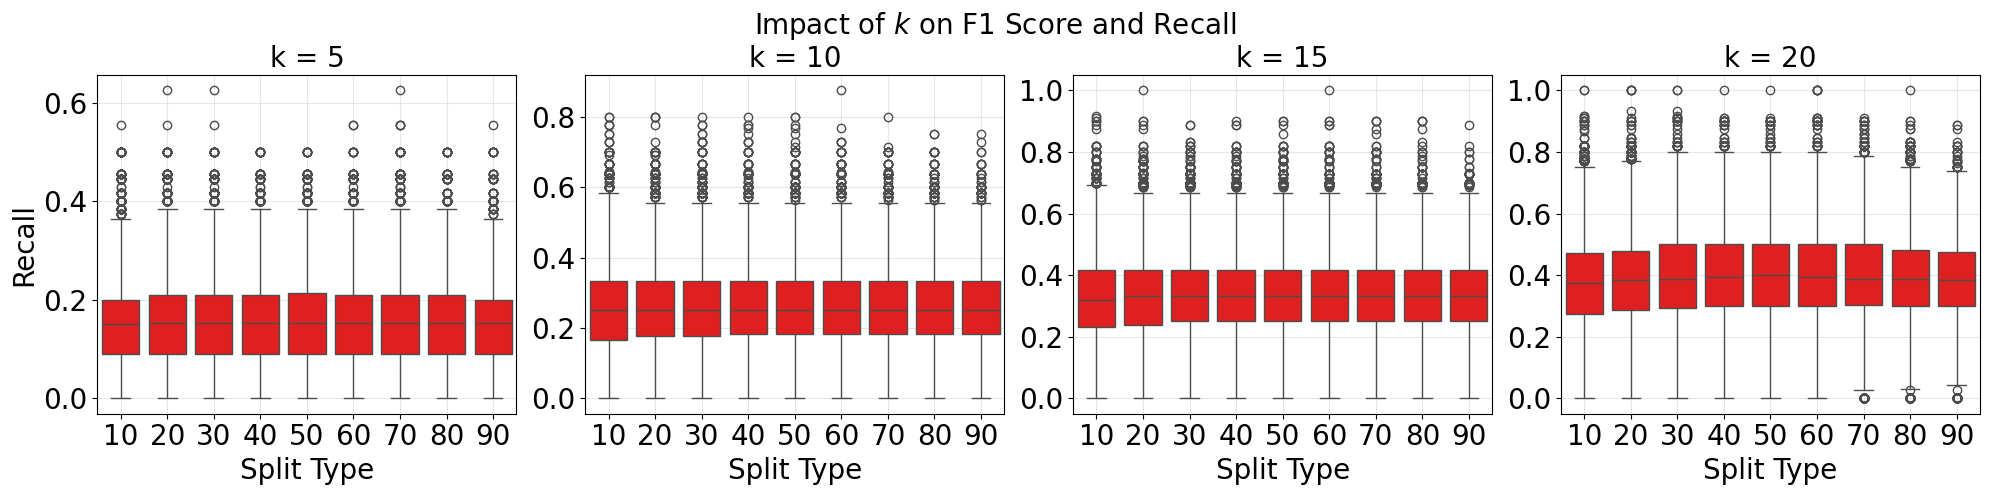

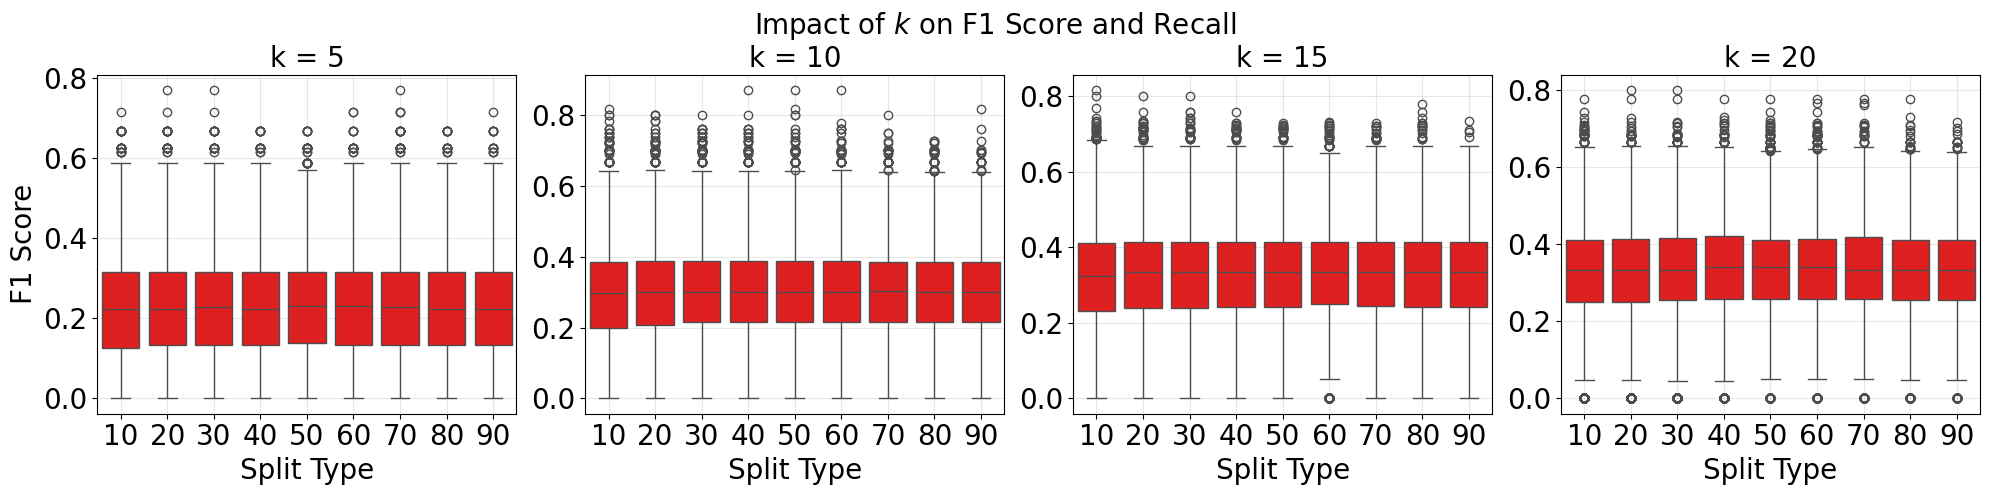

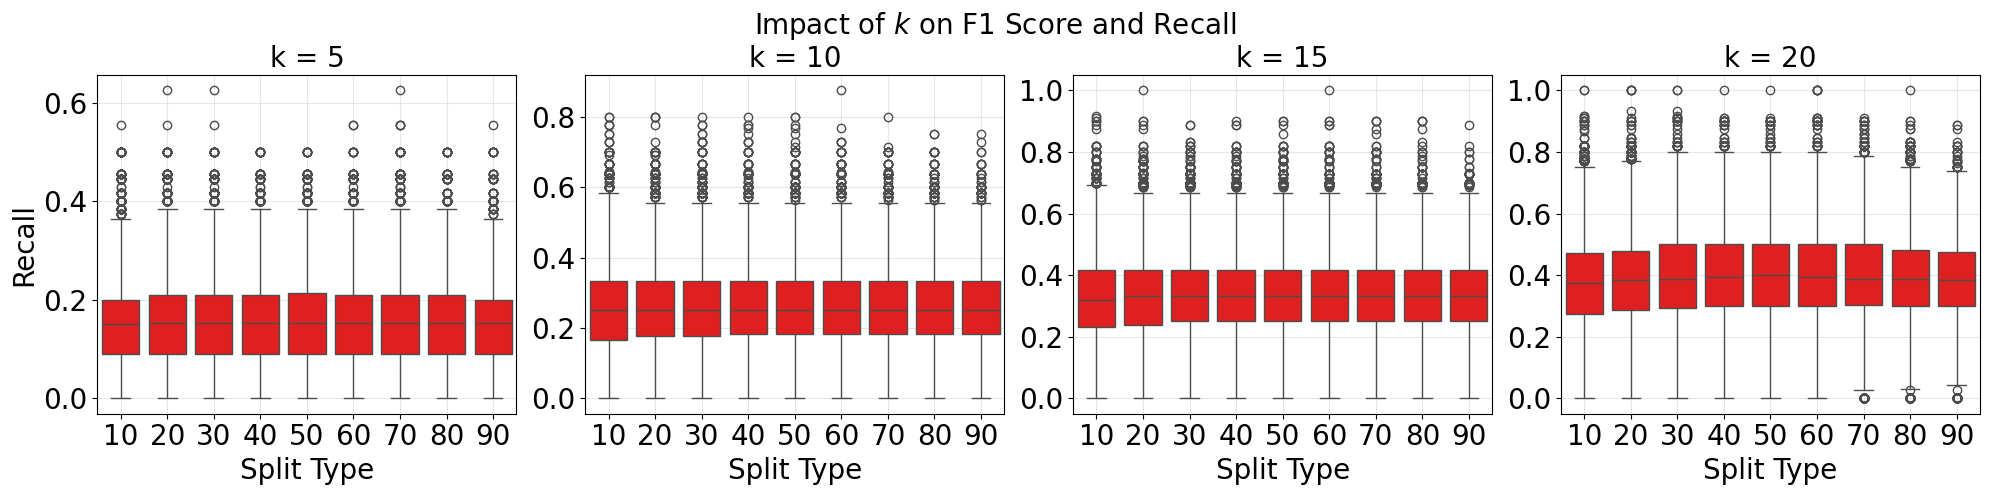

In [14]:
# plot_metrics_by_split(df, 'f1_score', color='red')
# plt.show()

# # You can also create plots for other metrics
# plot_metrics_by_split(df, 'precision', color='red')
# plt.show()

# plot_metrics_by_split(df, 'recall', color='red')
# plt.show()

plot_metrics_by_split(df, 'f1_score',
                     color='red', 
                     k_font_size=20,
                     score_font_size=20,
                     split_font_size=20,
                     title_font_size=20,
                     suptitle_font_size=20,
                     save_path='boxplots_txmt_f1.png')  # Will save with default 900 DPI

plot_metrics_by_split(df, 'recall',
                     color='red', 
                     k_font_size=20,
                     score_font_size=20,
                     split_font_size=20,
                     title_font_size=20,
                     suptitle_font_size=20,
                     save_path='boxplots_txmt_recall.png')  # Will save with default 900 DPI